# Approach

1. Compute pareto on code occurences - do manually for now - DONE
2. Generate lookup list based on top 80% - do manually for now - DONE
3. Replace codes with lookups in original categorical columns in claims file - DONE
4. Use pd.get_dummies to generate ohe columns - DONE (if then else loops)
5. Generate month, week, dayof month, day of week for - DONE
    - Claim start date
    - Claim end date
6. Compute derived variables - DONE
   - age bands - DONE
   - claim duration - already available
   - Lag Days - cannot 
5. Concatenate Beneficiary info - DONE
6. Consider mapping DX codes to HCC conditions to reduce sparseness
7. Drop columns - DONE IN EXCLUDE COLUMNS
    - SP_ columns
    - yearly sums
8. Figure out the proc string issue - 
9. Identify KPI transformations and replace nulls with medians - DONE
   - compute logs of KPIs

Outstanding
1. ...only read code values as str in read_csv of input datafile!!!!!

Later...
1. switch to outpatient
2. Replace DRG CD with ohe
3. Purchase actual CMS files for recent years if possible...say 10K records

# Columns info
- **CLM_ID: Claim ID**
- **DESYNPUF_ID:** Beneficiary Code
It's the identifier of the patient. Could be multiple claims per patient. 
- **SEGMENT:** Claim Line Segment. Drop.
- **CLM_FROM_DT:** Claims start date
- **CLM_THRU_DT:** Claims end date
- **PRVDR_NUM:** Provider Institution. Company who made the claim (hospital).
- **CLM_PMT_AMT:** Claim Payment Amount.
- **NCH_PRMRY_PYR_CLM_PD_AMT:** NCH Primary Payer Claim Paid Amount. One of the KPI's.
- **AT_PHYSN_NPI:** Attending Physician (physician who made the claim).
- **OP_PHYSN_NPI:** Operating Physician – National Provider Identifier Number.
- **OT_PHYSN_NPI:** Other Physician – National Provider Identifier Number.
- **CLM_ADMSN_DT:** Inpatient admission date.
- **ADMTNG_ICD9_DGNS_CD:**  Claim Admitting Diagnosis Code. Drop (in clustering)
- **CLM_PASS_THRU_PER_DIEM_AMT:** Claim Pass Thru Per Diem Amount
The amount of the established reimbursable costs for the current year divided by the estimated Medicare
days for the current year (all PPS claims), as calculated by the FI and reimbursement staff. Items
reimbursed as a pass through include capital–related costs; direct medical education costs; kidney
acquisition costs for hospitals approved as RTCs; and bad debts (per Provider Reimbursement Manual,
Part 1, Section 2405.2). Note: Pass through are not included in the Claim Payment Amount. 
- **NCH_BENE_IP_DDCTBL_AMT:** NCH Beneficiary Inpatient Deductible Amount
The amount of the deductible the beneficiary paid for inpatient services, as originally submitted on the
institutional claim. 
- **NCH_BENE_PTA_COINSRNC_LBLTY_AM:** NCH Beneficiary Part A Coinsurance Liability Amount
The amount of money for which the intermediary has determined that the beneficiary is liable for Part A
coinsurance on the institutional claim. 
- **CLM_UTLZTN_DAY_CNT:** Claim Utilization Day Count. 
On an institutional claim, the number of covered days of care that are chargeable to Medicare facility
utilization that includes full days, coinsurance days, and lifetime reserve days. It excludes any days
classified as non–covered, leave of absence days, and the day of discharge or death.
- **NCH_BENE_DSCHRG_DT:** Inpatient discharged date. 
Effective with Version H, on an inpatient and HHA claim, the date the beneficiary was discharged from
the facility or died (used for internal CWFMQA editing purposes.) 
- **CLM_DRG_CD:** Claim Diagnosis Related Group Code.
- **ICD9_DGNS_CD_1:** Line Diagnosis Code 1. For every claim in order to justify the claim the physician has to say the patient has been dignosed with the following conditions. I did the following procedures (1-10).
- **ICD9_DGNS_CD_2:** ???
- **ICD9_DGNS_CD_3:** ???
- **ICD9_DGNS_CD_4:** ???
- **ICD9_DGNS_CD_5:** ???
- **ICD9_DGNS_CD_6:** ???
- **ICD9_DGNS_CD_7:** ???
- **ICD9_DGNS_CD_8:** Claim Diagnosis Code 8
- **ICD9_DGNS_CD_9:** Diagonisis
- **ICD9_DGNS_CD_10:** Claim Diagnosis Code 10. Representing different conditions. 
- **ICD9_PRCDR_CD_1:** Procedure.
- **ICD9_PRCDR_CD_2:** ???
- **ICD9_PRCDR_CD_3:** ???
- **ICD9_PRCDR_CD_5:** ???
- **ICD9_PRCDR_CD_6:** Claim Procedure Code 6

# Using the following columns (for clustering)
- NCH_BENE_DSCHRG_DT. Inpatient discharged date. Effective with Version H, on an inpatient and HHA claim, the date the beneficiary was discharged from the facility or died (used for internal CWFMQA editing purposes.)
- NCH_PRMRY_PYR_CLM_PD_AMT: NCH Primary Payer Claim Paid Amount. One of the KPI's.
- CLM_FROM_DT: Claims start date
- CLM_THRU_DT: Claims end date
- CLM_ADMSN_DT: Inpatient admission date.
- PRVDR_NUM: Provider Institution. Company who made the claim (hospital).
- AT_PHYSN_NPI: Attending Physician (physician who made the claim).
- OP_PHYSN_NPI: Operating Physician – National Provider Identifier Number.
- ICD9_DGNS_CD_1
- ICD9_DGNS_CD_2
- ICD9_DGNS_CD_3
- ICD9_DGNS_CD_4
- ICD9_DGNS_CD_5
- ICD9_DGNS_CD_6
- ICD9_DGNS_CD_7
- ICD9_DGNS_CD_8
- ICD9_DGNS_CD_9
- ICD9_DGNS_CD_10

In [1]:
!pip install missingno

menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 2.2.3 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.2.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.1.0 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
# Imports
import pandas as pd
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#Plot styling/configurations 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 14,8
plt.rcParams['axes.facecolor']='white'
plt.rcParams.update({'font.size': 13})
import warnings
warnings.filterwarnings('ignore')
seq_col_brew = sns.color_palette("YlGnBu_r", 4)
sns.set_palette(seq_col_brew)
from __future__ import division, print_function, unicode_literals
from datetime import datetime
import numpy as np
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
data = pd.read_csv('DE1_0_2008_to_2010_Inpatient_Claims_NoHCPCS_Sample_1.csv', dtype=str)

In [4]:
data.drop(data[['CLM_ID', 'SEGMENT', 'ADMTNG_ICD9_DGNS_CD', 'DESYNPUF_ID']], axis = 1, inplace = True)

In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data.head()

,CLM_FROM_DT,CLM_THRU_DT,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_ADMSN_DT,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6
0,20100312,20100313,2600GD,4000,0,3139083564,NaN,NaN,20100312,0,1100,0,0,1,20100313,217,7802,78820,V4501,4280,2720,4019,V4502,73300,E9330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20090412,20090418,3900MB,26000,0,6476809087,NaN,NaN,20090412,0,1068,0,0,6,20090418,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20090831,20090902,3900HM,5000,0,611998537,611998537,NaN,20090831,0,1068,0,0,2,20090902,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092,6186,V5866,NaN,NaN,NaN
3,20090917,20090920,3913XU,5000,0,4971602784,NaN,1119000316,20090917,0,1068,0,0,3,20090920,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20100626,20100701,3900MB,16000,0,6408400473,1960859579,NaN,20100626,0,1100,0,0,5,20100701,983,3569,4019,3542,V8801,78820,2639,7840,7856,4271,NaN,NaN,E8889,NaN,NaN,NaN,NaN


In [7]:
data.shape

(44992, 32)

# Basic Analysis

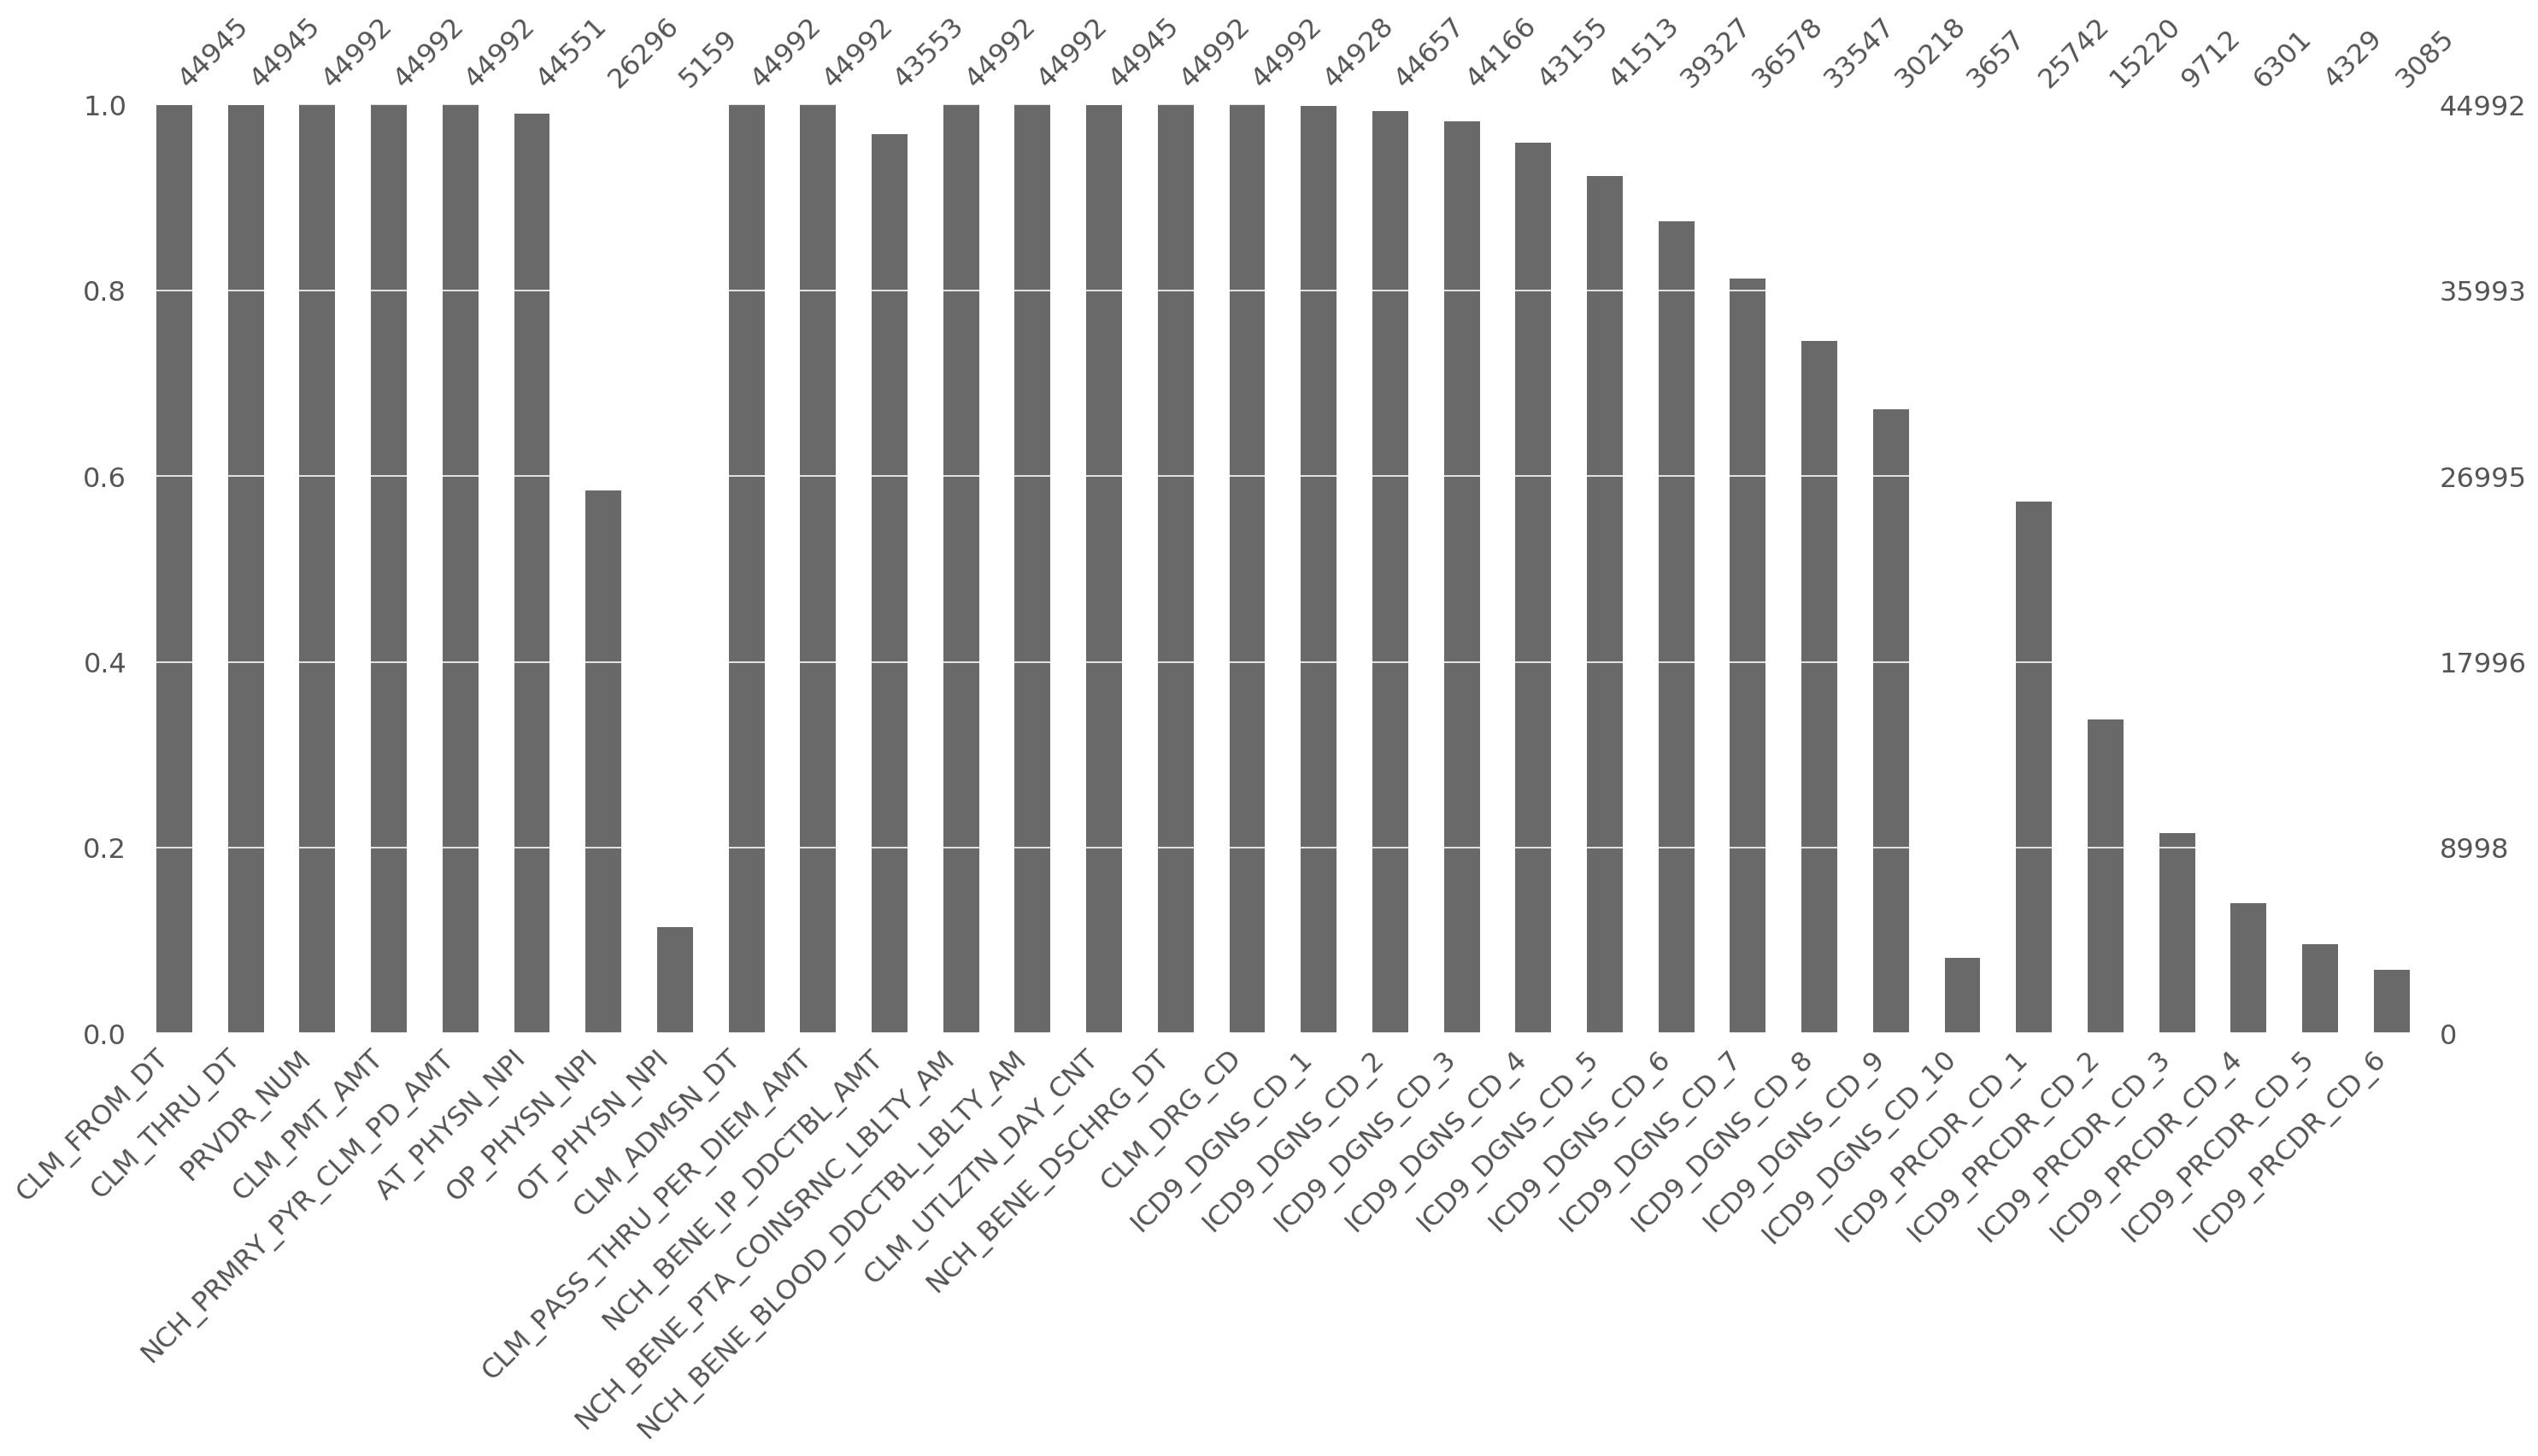

In [8]:
msno.bar(data)
plt.show()

# Feature Engineering Plan
CLM_FROM_DT - turn into date


CLM_THRU_DT - turn into date


PRVDR_NUM - categorical (2572 unique)


CLM_PMT_AMT - keep the same


NCH_PRMRY_PYR_CLM_PD_AMT - categorical (70 uniques)


AT_PHYSN_NPI - categorical (13147 uniques)


OP_PHYSN_NPI - categorical (9315 uniques)


OT_PHYSN_NPI - categorical (3213 uniques)


CLM_ADMSN_DT - turn into date


CLM_PASS_THRU_PER_DIEM_AMT - categorical


NCH_BENE_IP_DDCTBL_AMT - keep as is


NCH_BENE_PTA_COINSRNC_LBLTY_AM - keep as is


NCH_BENE_BLOOD_DDCTBL_LBLTY_AM - keep as is


CLM_UTLZTN_DAY_CNT - keep as is


NCH_BENE_DSCHRG_DT - turn to date.

CLM_DRG_CD - to categorical (unique 739)


ICD9_DGNS_CD_1 - to categorical (unique 2376)


ICD9_DGNS_CD_2 - to categorical (unique 2612)


ICD9_DGNS_CD_3 - to categorical (2529)


ICD9_DGNS_CD_4 - to categorical (2566)


ICD9_DGNS_CD_5 - to categorical (2541)


ICD9_DGNS_CD_6 - to categorical (2501)


ICD9_DGNS_CD_7 - to categorical (2452)


ICD9_DGNS_CD_8 - to categorical (2346)


ICD9_DGNS_CD_9 - to categorical (2216)


ICD9_DGNS_CD_10 - to categorical (922)


ICD9_PRCDR_CD_1 - to categorical (1140)


ICD9_PRCDR_CD_2 - to categorical (1696)


ICD9_PRCDR_CD_3 - to categorical (1413)


ICD9_PRCDR_CD_4 - to categorical (1132)


ICD9_PRCDR_CD_5 - to categorical (917)


ICD9_PRCDR_CD_6 - to categorical (727)

In [9]:
len(data['ICD9_PRCDR_CD_6'].unique())

727

# Feature Engineering

### CLM_FROM_DT

In [10]:
data['CLM_FROM_DT'].isnull().sum()

47

In [11]:
data['CLM_FROM_DT'].fillna(00000000, inplace=True)

In [12]:
data['CLM_FROM_DT'] = pd.to_datetime(data['CLM_FROM_DT'])

## CLM_THRU_DT

In [13]:
data['CLM_THRU_DT'].fillna(00000000, inplace=True)

In [14]:
data['CLM_THRU_DT'] = pd.to_datetime(data['CLM_THRU_DT'])

In [15]:
data['CLM_THRU_DT'].isnull().sum()

0

## PRVDR_NUM

In [16]:
data['PRVDR_NUM'] = data['PRVDR_NUM'].astype('category')
data['PRVDR_NUM'] = data['PRVDR_NUM'].cat.codes

In [17]:
data['PRVDR_NUM'].isnull().sum()

0

### NCH_PRMRY_PYR_CLM_PD_AMT

In [18]:
data['NCH_PRMRY_PYR_CLM_PD_AMT'].fillna(0, inplace=True)

In [19]:
data['NCH_PRMRY_PYR_CLM_PD_AMT'] = data['NCH_PRMRY_PYR_CLM_PD_AMT'].astype('category')
data['NCH_PRMRY_PYR_CLM_PD_AMT'] = data['NCH_PRMRY_PYR_CLM_PD_AMT'].cat.codes

### AT_PHYSN_NPI

In [20]:
data['AT_PHYSN_NPI'].isnull().sum()

441

In [21]:
data['AT_PHYSN_NPI'].fillna(0, inplace=True)

In [22]:
data['AT_PHYSN_NPI'] = data['AT_PHYSN_NPI'].astype('category')
data['AT_PHYSN_NPI'] = data['AT_PHYSN_NPI'].cat.codes

### OP_PHYSN_NPI

In [23]:
data['OP_PHYSN_NPI'] = data['OP_PHYSN_NPI'].astype('category')
data['OP_PHYSN_NPI'] = data['OP_PHYSN_NPI'].cat.codes

### OT_PHYSN_NPI 

In [24]:
data['OT_PHYSN_NPI'] = data['OT_PHYSN_NPI'].astype('category')
data['OT_PHYSN_NPI'] = data['OT_PHYSN_NPI'].cat.codes

### CLM_ADMSN_DT

In [25]:
data['CLM_ADMSN_DT'].isnull().sum()

0

In [26]:
data['CLM_ADMSN_DT'] = pd.to_datetime(data['CLM_ADMSN_DT'])

### CLM_PASS_THRU_PER_DIEM_AMT

In [27]:
data['CLM_PASS_THRU_PER_DIEM_AMT'].value_counts()

0      32250
10      1937
200     1523
100     1479
20      1217
30      1054
50       904
40       887
300      818
70       728
60       703
80       577
500      321
400      306
90       288
Name: CLM_PASS_THRU_PER_DIEM_AMT, dtype: int64

### NCH_BENE_IP_DDCTBL_AMT

In [28]:
data['NCH_BENE_IP_DDCTBL_AMT'].isnull().sum()

1439

In [29]:
data['NCH_BENE_IP_DDCTBL_AMT'].value_counts(ascending=True, dropna=False)

NaN      1439
1100     9308
1068    16749
1024    17496
Name: NCH_BENE_IP_DDCTBL_AMT, dtype: int64

In [30]:
data['NCH_BENE_IP_DDCTBL_AMT'].fillna(0, inplace=True)

### NCH_BENE_PTA_COINSRNC_LBLTY_AM

In [31]:
data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'].isnull().sum()

0

In [32]:
data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'] = data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'].astype('category')
data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'] = data['NCH_BENE_PTA_COINSRNC_LBLTY_AM'].cat.codes

### CLM_UTLZTN_DAY_CNT

In [33]:
data['CLM_UTLZTN_DAY_CNT'].isnull().sum()

47

In [34]:
data['CLM_UTLZTN_DAY_CNT'].fillna(0, inplace=True)

### NCH_BENE_DSCHRG_DT

In [35]:
data['NCH_BENE_DSCHRG_DT'] = data['NCH_BENE_DSCHRG_DT'].astype('category')
data['NCH_BENE_DSCHRG_DT'] = data['NCH_BENE_DSCHRG_DT'].cat.codes

### CLM_DRG_CD

In [36]:
data['CLM_DRG_CD'] = data['CLM_DRG_CD'].astype('category')
data['CLM_DRG_CD'] = data['CLM_DRG_CD'].cat.codes

### ICD9_DGNS_CD_1

In [37]:
data['ICD9_DGNS_CD_1'].isnull().sum()

64

In [38]:
data['ICD9_DGNS_CD_1'] = data['ICD9_DGNS_CD_1'].astype('category')
data['ICD9_DGNS_CD_1'] = data['ICD9_DGNS_CD_1'].cat.codes

### ICD9_DGNS_CD_2

In [39]:
data['ICD9_DGNS_CD_2'] = data['ICD9_DGNS_CD_2'].astype('category')
data['ICD9_DGNS_CD_2'] = data['ICD9_DGNS_CD_2'].cat.codes

### ICD9_DGNS_CD_3

In [40]:
data['ICD9_DGNS_CD_3'] = data['ICD9_DGNS_CD_3'].astype('category')
data['ICD9_DGNS_CD_3'] = data['ICD9_DGNS_CD_3'].cat.codes

In [41]:
data['ICD9_DGNS_CD_3'].isnull().sum()

0

### ICD9_DGNS_CD_4

In [42]:
data['ICD9_DGNS_CD_4'].isnull().sum()

1837

In [43]:
data['ICD9_DGNS_CD_4'].fillna(0, inplace=True)

In [44]:
data['ICD9_DGNS_CD_4'] = data['ICD9_DGNS_CD_4'].astype('category')
data['ICD9_DGNS_CD_4'] = data['ICD9_DGNS_CD_4'].cat.codes

### ICD9_DGNS_CD_5

In [45]:
data['ICD9_DGNS_CD_5'].fillna(0, inplace=True)

In [46]:
data['ICD9_DGNS_CD_5'].isnull().sum()

0

In [47]:
data['ICD9_DGNS_CD_5'] = data['ICD9_DGNS_CD_5'].astype('category')
data['ICD9_DGNS_CD_5'] = data['ICD9_DGNS_CD_5'].cat.codes

### ICD9_DGNS_CD_6

In [48]:
data['ICD9_DGNS_CD_6'].fillna(0, inplace=True)

In [49]:
data['ICD9_DGNS_CD_6'].isnull().sum()

0

In [50]:
data['ICD9_DGNS_CD_6'] = data['ICD9_DGNS_CD_6'].astype('category')
data['ICD9_DGNS_CD_6'] = data['ICD9_DGNS_CD_6'].cat.codes

### ICD9_DGNS_CD_7

In [51]:
data['ICD9_DGNS_CD_7'].isnull().sum()

8414

In [52]:
data['ICD9_DGNS_CD_7'].fillna(0, inplace=True)

In [53]:
data['ICD9_DGNS_CD_7'] = data['ICD9_DGNS_CD_7'].astype('category')
data['ICD9_DGNS_CD_7'] = data['ICD9_DGNS_CD_7'].cat.codes

### ICD9_DGNS_CD_8

In [54]:
data['ICD9_DGNS_CD_8'].isnull().sum()

11445

In [55]:
data['ICD9_DGNS_CD_8'].fillna(0, inplace=True)

In [56]:
data['ICD9_DGNS_CD_8'] = data['ICD9_DGNS_CD_8'].astype('category')
data['ICD9_DGNS_CD_8'] = data['ICD9_DGNS_CD_8'].cat.codes

### ICD9_DGNS_CD_9

In [57]:
data['ICD9_DGNS_CD_9'].isnull().sum()

14774

In [58]:
data['ICD9_DGNS_CD_9'].fillna(0, inplace=True)

In [59]:
data['ICD9_DGNS_CD_9'] = data['ICD9_DGNS_CD_9'].astype('category')
data['ICD9_DGNS_CD_9'] = data['ICD9_DGNS_CD_9'].cat.codes

### ICD9_DGNS_CD_10

In [60]:
data['ICD9_DGNS_CD_10'].isnull().sum()

41335

In [61]:
data['ICD9_DGNS_CD_10'].fillna(0, inplace=True)

In [62]:
data['ICD9_DGNS_CD_10'] = data['ICD9_DGNS_CD_10'].astype('category')
data['ICD9_DGNS_CD_10'] = data['ICD9_DGNS_CD_10'].cat.codes

### ICD9_PRCDR_CD_1

In [63]:
data['ICD9_PRCDR_CD_1'].isnull().sum()

19250

In [64]:
data['ICD9_PRCDR_CD_1'].fillna(0, inplace=True)

In [65]:
data['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].astype('category')
data['ICD9_PRCDR_CD_1'] = data['ICD9_PRCDR_CD_1'].cat.codes

### ICD9_PRCDR_CD_2

In [66]:
data['ICD9_PRCDR_CD_2'].isnull().sum()

29772

In [67]:
data['ICD9_PRCDR_CD_2'].fillna(0, inplace=True)

In [68]:
data['ICD9_PRCDR_CD_2'] = data['ICD9_PRCDR_CD_2'].astype('category')
data['ICD9_PRCDR_CD_2'] = data['ICD9_PRCDR_CD_2'].cat.codes

### ICD9_PRCDR_CD_3

In [69]:
data['ICD9_PRCDR_CD_3'].isnull().sum()

35280

In [70]:
data['ICD9_PRCDR_CD_3'].fillna(0, inplace=True)

In [71]:
data['ICD9_PRCDR_CD_3'] = data['ICD9_PRCDR_CD_3'].astype('category')
data['ICD9_PRCDR_CD_3'] = data['ICD9_PRCDR_CD_3'].cat.codes

### ICD9_PRCDR_CD_4

In [72]:
data['ICD9_PRCDR_CD_4'].isnull().sum()

38691

In [73]:
data['ICD9_PRCDR_CD_4'].fillna(0, inplace=True)

In [74]:
data['ICD9_PRCDR_CD_4'] = data['ICD9_PRCDR_CD_4'].astype('category')
data['ICD9_PRCDR_CD_4'] = data['ICD9_PRCDR_CD_4'].cat.codes

### ICD9_PRCDR_CD_5

In [75]:
data['ICD9_PRCDR_CD_5'].isnull().sum()

40663

In [76]:
data['ICD9_PRCDR_CD_5'].fillna(0, inplace=True)

In [77]:
data['ICD9_PRCDR_CD_5'] = data['ICD9_PRCDR_CD_5'].astype('category')
data['ICD9_PRCDR_CD_5'] = data['ICD9_PRCDR_CD_5'].cat.codes

### ICD9_PRCDR_CD_6

In [78]:
data['ICD9_PRCDR_CD_6'].isnull().sum()

41907

In [79]:
data['ICD9_PRCDR_CD_6'].fillna(0, inplace=True)

In [80]:
data['ICD9_PRCDR_CD_6'] = data['ICD9_PRCDR_CD_6'].astype('category')
data['ICD9_PRCDR_CD_6'] = data['ICD9_PRCDR_CD_6'].cat.codes

### Breaking down datetime to individual columns

In [81]:
data['CLM_FROM_DT_year'] = data['CLM_FROM_DT'].dt.year
data['CLM_FROM_DT_month'] = data['CLM_FROM_DT'].dt.month
data['CLM_FROM_DT_day'] = data['CLM_FROM_DT'].dt.day

In [82]:
data['CLM_THRU_DT_year'] = data['CLM_THRU_DT'].dt.year
data['CLM_THRU_DT_month'] = data['CLM_THRU_DT'].dt.month
data['CLM_THRU_DT_day'] = data['CLM_THRU_DT'].dt.day

In [83]:
data['CLM_ADMSN_DT_year'] = data['CLM_ADMSN_DT'].dt.year
data['CLM_ADMSN_DT_month'] = data['CLM_ADMSN_DT'].dt.month
data['CLM_ADMSN_DT_day'] = data['CLM_ADMSN_DT'].dt.day

In [84]:
data.drop(data[['CLM_FROM_DT', 'CLM_THRU_DT', 'CLM_ADMSN_DT']], axis=1, inplace=True)

In [85]:
data.head()

,PRVDR_NUM,CLM_PMT_AMT,NCH_PRMRY_PYR_CLM_PD_AMT,AT_PHYSN_NPI,OP_PHYSN_NPI,OT_PHYSN_NPI,CLM_PASS_THRU_PER_DIEM_AMT,NCH_BENE_IP_DDCTBL_AMT,NCH_BENE_PTA_COINSRNC_LBLTY_AM,NCH_BENE_BLOOD_DDCTBL_LBLTY_AM,CLM_UTLZTN_DAY_CNT,NCH_BENE_DSCHRG_DT,CLM_DRG_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,ICD9_DGNS_CD_6,ICD9_DGNS_CD_7,ICD9_DGNS_CD_8,ICD9_DGNS_CD_9,ICD9_DGNS_CD_10,ICD9_PRCDR_CD_1,ICD9_PRCDR_CD_2,ICD9_PRCDR_CD_3,ICD9_PRCDR_CD_4,ICD9_PRCDR_CD_5,ICD9_PRCDR_CD_6,CLM_FROM_DT_year,CLM_FROM_DT_month,CLM_FROM_DT_day,CLM_THRU_DT_year,CLM_THRU_DT_month,CLM_THRU_DT_day,CLM_ADMSN_DT_year,CLM_ADMSN_DT_month,CLM_ADMSN_DT_day
0,1290,4000,0,3124,-1,-1,0,1100,0,0,1,802,90,1796,1876,2393,833,266,723,2325,1528,1950,0,0,0,0,0,0,0,2010,3,12,2010,3,13,2010,3,12
1,1904,26000,0,7997,-1,-1,0,1068,0,0,6,473,79,157,742,1297,1758,299,1518,258,92,1157,0,0,0,0,0,0,0,2009,4,12,2009,4,18,2009,4,12
2,1901,5000,0,7462,5313,-1,0,1068,0,0,2,610,556,1471,391,1202,0,0,0,0,0,0,0,652,941,1380,0,0,0,2009,8,31,2009,9,2,2009,8,31
3,1958,5000,0,5846,-1,35,0,1068,0,0,3,628,657,499,455,1537,574,2369,522,0,0,0,0,0,0,0,0,0,0,2009,9,17,2009,9,20,2009,9,17
4,1904,16000,0,7898,1046,-1,0,1100,0,0,5,912,728,688,742,616,2565,1807,242,1705,1659,731,0,0,1481,0,0,0,0,2010,6,26,2010,7,1,2010,6,26


# Memory optimization

In [86]:
data.memory_usage().sum()

7108816

In [87]:
data.dtypes

PRVDR_NUM                          int16
CLM_PMT_AMT                       object
NCH_PRMRY_PYR_CLM_PD_AMT            int8
AT_PHYSN_NPI                       int16
OP_PHYSN_NPI                       int16
OT_PHYSN_NPI                       int16
CLM_PASS_THRU_PER_DIEM_AMT        object
NCH_BENE_IP_DDCTBL_AMT            object
NCH_BENE_PTA_COINSRNC_LBLTY_AM      int8
NCH_BENE_BLOOD_DDCTBL_LBLTY_AM    object
CLM_UTLZTN_DAY_CNT                object
NCH_BENE_DSCHRG_DT                 int16
CLM_DRG_CD                         int16
ICD9_DGNS_CD_1                     int16
ICD9_DGNS_CD_2                     int16
ICD9_DGNS_CD_3                     int16
ICD9_DGNS_CD_4                     int16
ICD9_DGNS_CD_5                     int16
ICD9_DGNS_CD_6                     int16
ICD9_DGNS_CD_7                     int16
ICD9_DGNS_CD_8                     int16
ICD9_DGNS_CD_9                     int16
ICD9_DGNS_CD_10                    int16
ICD9_PRCDR_CD_1                    int16
ICD9_PRCDR_CD_2 

In [88]:
for i in data.columns:
    if data[i].dtypes == 'int64':
        data[i] = data[i].astype('uint16')
    if data[i].dtypes == 'int16':
        data[i] = data[i].astype('uint16')
    if data[i].dtypes == 'object':
        data[i] = data[i].astype('uint16')
    if data[i].dtypes == 'datetime64[ns]':
        data[i] = data[i].astype('uint16')

In [89]:
data.memory_usage().sum()

3329488

46% memory usage savings

In [90]:
3329488 / 7108816 * 100

46.83604133234001

In [91]:
data.shape

(44992, 38)

# Plot analysis

# PCA

In [92]:
random_s = 0
clusters = 8

In [96]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca = PCA(n_components=2)
pca_data = pca.fit(data)

In [97]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=clusters, n_init=10)
kmeans.fit(reduced_data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [98]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

MemoryError: 

# Applying model

In [ ]:
% time
kmeans = KMeans(n_clusters=6, random_state=0).fit(data)

In [ ]:
kmeans

In [ ]:
% time

kmeans = KMeans(n_clusters=clusters, random_state=random_s)
kmeans.fit(data)
y_kmeans = kmeans.predict(data)

In [ ]:
centers = kmeans.cluster_centers_

In [ ]:
plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(data)